In [2]:
#accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
# How about visualization?
%matplotlib inline
import xrft
import netCDF4
import xgcm
from netCDF4 import Dataset
from xmitgcm import open_mdsdataset
from GetNCDataSet import getMITNCDataSet
from MIT_xr_cwt_dateloc_fol import loadMITData
from MITllc2160Depth import *



from dask.distributed import Client
#client = Client(memory_limit='90GB',n_workers = 40, threads_per_worker=1)

So in this notebook, we're hoping to wrap up an idea of where to integrate vertically to calculate mixed layer temperature variance budget. I'll be trying to do a few things at the same time - 1. I'm going to do a sensitivity study of the budget balance as a function of integration depth and 2. I'm going to look at frequency wavenumber spectra for theta at various depths

In [11]:
zlayerToDepth(38)

473.30499999999995

So we should download 40 layers and do the sum to layer 40 and 38 and compare for the first few months

In [4]:
hbl = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month/', 'KPPhbl', 0,0 )

Time combined dataset has been opened.
I concatenated the first Z-layer


In [12]:
hblc = hbl.compute()

In [15]:
def coarseGrainHbl_SUNRISE(hblset):
    periodlength = 24
    periodnum = int(hblset.dims['time'] / periodlength)
    hblsel = hblset['KPPhbl']
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    sunrisetime = 10 #NOTE IN A FINAL VERSION OF THIS CODE, SUNRISE TIME WILL BE A FUNCTION OF LONGITUDE
    for index in range(0,periodnum):
        perioddepths[index] = hblsel[index*periodlength + sunrisetime].values
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hSUNRISE = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hSUNRISE

In [14]:
%matplotlib inline
hblcm = hblc.max(dim=['lat','lon'])

In [16]:
hblcmcg = coarseGrainHbl_SUNRISE(hblcm)

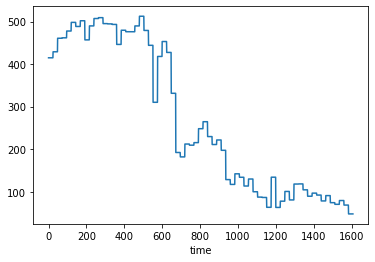

In [18]:
%matplotlib inline
hblcmcg.plot()

In [20]:
SST = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 0,0 )

Time combined dataset has been opened.
I concatenated the first Z-layer


In [21]:
SSTc = SST.compute()
SSTc

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 625, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -65.0 -64.96 -64.92 -64.88 ... -40.12 -40.08 -40.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 20.43 20.42 20.43 ... 15.25 15.26 15.09

I'm going to start by calculating spectra of SST just for the exercise - I should be able to see some kind of frequency peaks here.

In [28]:
SSTw = SSTc.sel(time=slice(0,600)) #splitting the variable into the winter and summer regimes
SSTs = SSTc.sel(time=slice(700,-1))

Spectra and Sums

Sums: I'm going to have to revisit and ideally parallelize all my code for this. That means going back to notebook 14 and doing xarray stuff
1. Figure out the most efficient way to add all these layers accurately.

Spectra: What's the procedure
1. Scale variables to what you want earlier (so days instead of hours for example, km instead of lat lon)
2. Detrend in space and time (fit to trend like Brian says)
3. Window - you'll have to play with xrft to get this part working, especially for normalizing the thing
4. FFT
5. Correctly deal with frequencies 
6. Normalize - the dx normalization is handled by doing true_amplitude
7. Normalize by window
8. Check Parseval's theorem  - do this before making it isotropic
9. Isotropize
10. Plot and add plot labels